In [1]:
cd ..

/home/abhishekabhishek/git/AQT-KimGroup


This notebook can be used to qualitatively and quantitatively compare the density matrix reconstruction by standard linear inversion and AQT.

In [19]:
from qiskit import IBMQ, QuantumCircuit
import numpy as np
import os
from qiskit.quantum_info import state_fidelity

from circuits import state_prep
from fidelity import plotDM

%matplotlib inline

Setup access to IBM

In [3]:
# Setup account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

# Find available devices
devices = provider.backends(operational=True)
for x in devices:
    print(x.name(), x.configuration().n_qubits, x.status().pending_jobs)

ibmq_qasm_simulator 32 3
ibmq_lima 5 144
ibmq_belem 5 2
ibmq_quito 5 26
simulator_statevector 32 0
simulator_mps 100 0
simulator_extended_stabilizer 63 0
simulator_stabilizer 5000 0
ibmq_manila 5 39
ibm_nairobi 7 33
ibm_oslo 7 29


In [4]:
# Use one of the backends above
sim_backend = provider.backend.ibmq_qasm_simulator

Use qiskit_experiments library to perform tomogrpahy

In [5]:
from qiskit_experiments.library import StateTomography

In [58]:
# System setup
n_qubits = 3
n_shots = 100

# Initialize the circuit
circ = QuantumCircuit(n_qubits)

# Choose which type of state to prepare
# One of ghz, w, bisep, random
state = 'ghz'

In [59]:
if state == 'ghz':
    circ.h(0)
    for idx in range(n_qubits-1):
        circ.cx(idx, idx+1)
elif state == 'w':
    if n_qubits == 3:
        circ.ry(1.9106332362490184, 0)
        circ.cu((np.pi/2), (np.pi/2), (np.pi/2), (np.pi/2), 0, 1)
        circ.cx(1, 2)
        circ.cx(0, 1)
        circ.x(0)
    else:
        circ = state_prep.create_w_state(n_qubits)
elif state == 'bisep':
    raise NotImplementedError
elif state == 'random':
    for idx in range(n_qubits):
        circ.h(idx)
        
# Draw the circuit
circ.draw() 

┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐     
q_1: ─────┤ X ├──■──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

In [45]:
# No. of tomography circuits to draw
n_draw = 3

# POVM to use
povm = 'pauli6'

# Initalize the tomography circuits
qst_exp = StateTomography(circ)
qst_data = qst_exp.run(sim_backend, seed_simulation=100, 
                       shots=n_shots).block_for_results()

# Draw the tomogrpahy circuits
for circuit in qst_exp.circuits()[:n_draw]:
    print(circuit.draw())

     ┌────────────┐                                ┌───┐ ░ ┌────────────┐ ░ ┌─┐»
q_0: ┤ Ry(1.9106) ├──────────■──────────────────■──┤ X ├─░─┤ PauliMeasZ ├─░─┤M├»
     └────────────┘┌─────────┴──────────┐     ┌─┴─┐└───┘ ░ ├────────────┤ ░ └╥┘»
q_1: ──────────────┤ U(π/2,π/2,π/2,π/2) ├──■──┤ X ├──────░─┤ PauliMeasZ ├─░──╫─»
                   └────────────────────┘┌─┴─┐└───┘      ░ ├────────────┤ ░  ║ »
q_2: ────────────────────────────────────┤ X ├───────────░─┤ PauliMeasZ ├─░──╫─»
                                         └───┘           ░ └────────────┘ ░  ║ »
c_0: ════════════════════════════════════════════════════════════════════════╩═»
                                                                               »
c_1: ══════════════════════════════════════════════════════════════════════════»
                                                                               »
c_2: ══════════════════════════════════════════════════════════════════════════»
                            

Analyze the results

In [46]:
# Print results
for result in qst_data.analysis_results():
    print(result)

AnalysisResult
- name: state
- value: DensityMatrix([[ 2.58559091e-02+0.00000000e+00j,
                -1.42843691e-02+1.05466768e-02j,
                 4.66257701e-03+1.02233147e-02j,
                -1.27217450e-03+9.99083603e-03j,
                 1.62813619e-02-2.34958474e-03j,
                 1.18885741e-02+6.67361366e-03j,
                 5.74621437e-03-8.39393356e-03j,
                -1.03255836e-02+1.56228375e-02j],
               [-1.42843691e-02-1.05466768e-02j,
                 3.08165622e-01+0.00000000e+00j,
                 2.49269894e-02-3.19566361e-01j,
                 4.57927001e-03+8.80646347e-03j,
                -2.91828606e-01-2.23407898e-02j,
                -2.29169337e-04-5.44563482e-03j,
                 5.28664939e-03+1.70541267e-02j,
                -1.09089837e-02+1.80378260e-02j],
               [ 4.66257701e-03-1.02233147e-02j,
                 2.49269894e-02+3.19566361e-01j,
                 3.43889929e-01-1.38777878e-17j,
                -7.15109280e-

In [47]:
state_result = qst_data.analysis_results("state")
print(state_result.value)

DensityMatrix([[ 2.58559091e-02+0.00000000e+00j,
                -1.42843691e-02+1.05466768e-02j,
                 4.66257701e-03+1.02233147e-02j,
                -1.27217450e-03+9.99083603e-03j,
                 1.62813619e-02-2.34958474e-03j,
                 1.18885741e-02+6.67361366e-03j,
                 5.74621437e-03-8.39393356e-03j,
                -1.03255836e-02+1.56228375e-02j],
               [-1.42843691e-02-1.05466768e-02j,
                 3.08165622e-01+0.00000000e+00j,
                 2.49269894e-02-3.19566361e-01j,
                 4.57927001e-03+8.80646347e-03j,
                -2.91828606e-01-2.23407898e-02j,
                -2.29169337e-04-5.44563482e-03j,
                 5.28664939e-03+1.70541267e-02j,
                -1.09089837e-02+1.80378260e-02j],
               [ 4.66257701e-03-1.02233147e-02j,
                 2.49269894e-02+3.19566361e-01j,
                 3.43889929e-01-1.38777878e-17j,
                -7.15109280e-03+5.16525546e-03j,
                -2

In [48]:
fid_result = qst_data.analysis_results("state_fidelity")
print("State Fidelity = {:.5f}".format(fid_result.value))

State Fidelity = 0.92228


Using a different fitter for the reconstruction

In [14]:
try:
    import cvxpy

    # Set analysis option for cvxpy fitter
    qst_exp.analysis.set_options(fitter='cvxpy_gaussian_lstsq')

    # Re-run experiment
    qst_data_2 = qst_exp.run(sim_backend, seed_simulation=100).block_for_results()

    state_result_2 = qst_data_2.analysis_results("state")
    print(state_result_2)
    print("\nextra:")
    for key, val in state_result_2.extra.items():
        print(f"- {key}: {val}")

except ModuleNotFoundError:
    print("CVXPY is not installed")

AnalysisResult
- name: state
- value: DensityMatrix([[ 1.93223105e-05+0.00000000e+00j,
                -4.53299847e-04-2.34359804e-04j,
                -2.33995381e-04+4.56519426e-04j,
                 1.06684932e-06-8.59855226e-07j,
                 4.55025139e-04+2.27120726e-04j,
                 1.03786849e-06-7.04151444e-07j,
                -1.14074749e-06-2.12617045e-06j,
                -5.01645176e-07+3.13917281e-07j],
               [-4.53299847e-04+2.34359804e-04j,
                 3.32780672e-01+0.00000000e+00j,
                -1.23419221e-03-3.34551038e-01j,
                -3.48520744e-04+8.35020807e-04j,
                -3.31720868e-01+4.71290745e-03j,
                -3.94314572e-04+7.16179454e-04j,
                 1.30267482e-03+8.97554589e-04j,
                 1.97853626e-04-3.35322830e-04j],
               [-2.33995381e-04-4.56519426e-04j,
                -1.23419221e-03+3.34551038e-01j,
                 3.36364636e-01+0.00000000e+00j,
                -8.38288018e-

In [38]:
type(qst_data_2.analysis_results)

qiskit_experiments.framework.experiment_data.ExperimentData

In [16]:
print(state_result_2.value)
fid_result = qst_data_2.analysis_results("state_fidelity")
print("State Fidelity = {:.5f}".format(fid_result.value))

DensityMatrix([[ 1.93223105e-05+0.00000000e+00j,
                -4.53299847e-04-2.34359804e-04j,
                -2.33995381e-04+4.56519426e-04j,
                 1.06684932e-06-8.59855226e-07j,
                 4.55025139e-04+2.27120726e-04j,
                 1.03786849e-06-7.04151444e-07j,
                -1.14074749e-06-2.12617045e-06j,
                -5.01645176e-07+3.13917281e-07j],
               [-4.53299847e-04+2.34359804e-04j,
                 3.32780672e-01+0.00000000e+00j,
                -1.23419221e-03-3.34551038e-01j,
                -3.48520744e-04+8.35020807e-04j,
                -3.31720868e-01+4.71290745e-03j,
                -3.94314572e-04+7.16179454e-04j,
                 1.30267482e-03+8.97554589e-04j,
                 1.97853626e-04-3.35322830e-04j],
               [-2.33995381e-04-4.56519426e-04j,
                -1.23419221e-03+3.34551038e-01j,
                 3.36364636e-01+0.00000000e+00j,
                -8.38288018e-04-3.53421292e-04j,
                -3

Load the density matrix from the disk

In [17]:
# datapath from AQT.py
datapath = 'data/w_3/pauli6_2700'

# Hyper-parameters
Nq = 3
Nep = 100
Nl = 2
dmodel = 64
Nh = 4
    
model_filetag = f'{datapath}_{Nep}-{Nl}-{dmodel}-{Nh}'

dm_model = np.load('{}_dm.npy'.format(model_filetag))

(<Figure size 640x480 with 1 Axes>, <Axes3DSubplot: >)

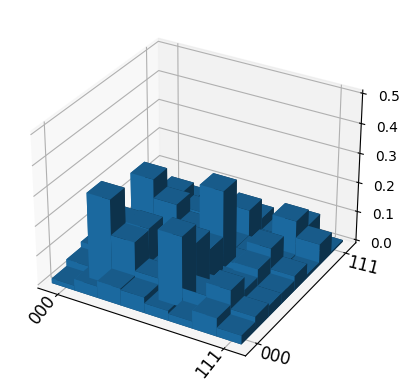

In [20]:
plotDM(dm_model, Nq)

In [35]:
dm_ibmq = state_result_2.value.data

(<Figure size 640x480 with 1 Axes>, <Axes3DSubplot: >)

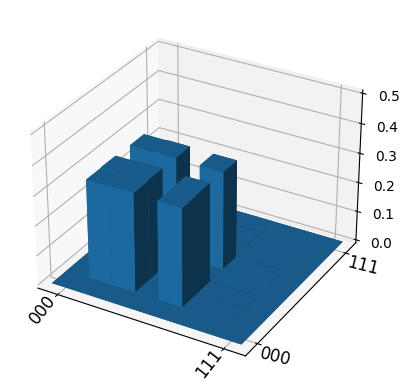

In [37]:
plotDM(dm_ibmq, Nq)

In [41]:
dm_ideal = DensityMatrix(circ)

(<Figure size 640x480 with 1 Axes>, <Axes3DSubplot: >)

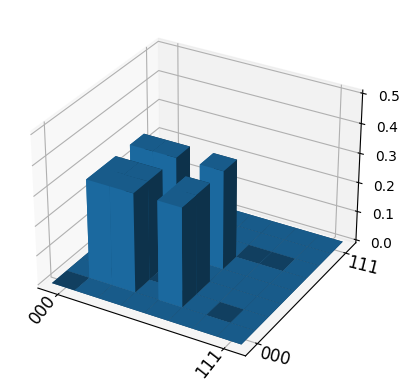

In [44]:
plotDM(dm_ideal.data, Nq)

In [53]:
dm_ibmq = qst_data.analysis_results("state").value.data

In [57]:
print(state_fidelity(dm_ibmq, dm_ideal))
print(state_fidelity(dm_model, dm_ideal, validate=False))

0.922278165946541
0.6218147009289353
